## Introduction to Water Observations from Space

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | May 16, 2019 |
| Last edited: | May 27, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

This notebook assumes you have cloned the dea-notebooks repository by following the instructions on [DEA notebooks using command line git](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-command-line-git) or [DEA notebooks using Github](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-github). If you didn't, you will need to download any scripts that fail in the first cell into your relative directory so that the notebook will have access to those scripts. `"../"` means the directory above the directory you are working in, and `"./"` means the current directory. 

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Background:__ Water Observations from Space (WOfS) is a suite of Australian continental surface water products. 


|WOfS products include:||
|----------|----------------|
| WOfS summary | this is the all-time summary |
|  WOfS filtered summary | the all time summary, checked against the confidence layer |
|  WOfS seasonal summaries | summaries for seasons |
| WOFLs (WOfS Feature Layers)|the daily WOfS slices |
 

__What does this notebook do?:__ This notebook talks about the WOfS datasets and demonstrates how to retrieve and save data for a location of interest.

## What is WOfS? [[1, 2](#References)]

The Water Observations from Space products are generated using the WOfS classification  algorithm. The WOfS algorithm classifies open water pixels. [1](https://doi.org/10.1016/j.rse.2015.11.003) There are several WOfS products:

__WOfS Filtered Summary:__ The percentage of time a pixel was wet, with confidence. The WOfS Filtered Summary is the definitive product. It has a confidence layer and a filtered summary. The Filtered Summary is the WOfS Summary, and areas with less than 10% Confidence have been removed. [WOfS Filtered Summary Product Description](https://data.dea.ga.gov.au/WOfS/filtered_summary/v2.1.0/Product%20Description.pdf)


__WOfS Summary:__ The percentage of time a pixel was classified as wet, using the WOfS classification algorithm. [WOfS Statistics Product Description](https://cmi.ga.gov.au/wo-stats_25_2.1.5)

- Total number of clear observations for the pixel, is a count per pixel of the number of observations that were clear and either wet or dry for the time period.
- Total number of wet observation for the pixel, is a count per pixel of the number of observations that were clear and wet for the time period.
- Summary, is the ratio of clear wet observations to clear wet or dry observation, expressed as a percentage.


__WOfS Seasonal Summaries:__ WOfS Summaries created for seasons 

__WOfLs (WOfS Feature Layers):__ WOfS Daily observations
    
### Limitations, Errors and Uncertainty:

__Limitations:__

http://www.ga.gov.au/scientific-topics/hazards/flood/wofs/about-wofs




## How to retrieve and plot the data

## Import modules from standard libraries, datacube and files
Select 'Trust this notebook' to import these modules.

In [1]:
%matplotlib inline
#get a bunch of python modules that we can use to calculate and plot
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

#modules for datacube
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser
#write to netcdf moved?

# Import external functions from dea-notebooks
sys.path.append('../10_Scripts/')
import DEAPlotting, DEADataHandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

%load_ext autoreload

%autoreload 2

### Edit save file path to choose where to save your output files

In [18]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath = os.path.expanduser('~/')

### WOfS products available from Digital Earth Australia as at 16/05/2019:

In [2]:
# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-WOfS')
#display product name and descriptions, where the name of the product contains 'wofs'
products = dc.list_products()
#change pandas setting to display all column contents
pd.set_option('display.max_colwidth', -1)
display_columns = ['name', 'description']
dc_products = products[display_columns]
dc_products[dc_products['name'].str.contains("wofs")]

,name,description
id,,
77,wofs_albers,Historic Flood Mapping Water Observations from Space
97,wofs_annual_summary,Water Observations from Space Annual Statistics
100,wofs_apr_oct_summary,Water Observations from Space April to October Statistics
85,wofs_filtered_summary,Water Observations from Space Statistics confidence filtered
101,wofs_nov_mar_summary,Water Observations from Space November to March Statistics
84,wofs_summary,Water Observations from Space Statistics


### WOfS ancillary datasets (used to create wofs confidence)

In [3]:
dc_products[dc_products['description'].str.contains("wofs")]

,name,description
id,,
88,dsm,"dsm ancillary data for wofs confidence, 25 metre, 100km tiles, Australian Albers Equal Area projection"
87,modis,Modis ancillary data for wofs confidence
86,mrvbf,MrVBF ancillary data for wofs confidence
89,urban_areas,urbanAreas ancillary data for wofs confidence


## Now let's load some WOfS data

### Specify the *query* with the coordinates and date range

The *query* is what you are asking the datacube to return. 

- **lat/lon:** Latitude and longitude of the area. e.g. Canberra = 'lat': (-35.25, -35.35), 'lon': (149.05, 149.17)
- **time:** Date range to fetch the scenes. The approximate time between two scenes is 16 days. If there is a location near a swath boundary, it may be captured in two passes and so there could be two images within the 16 day period.
- **buffer:* this query is set to run for a point with a buffer around it (in metres).
- **crs:** the coordinate reference system of the query. EPSG 3577 is Australian Albers. EPSG 4326 is WGS 84 , geographic. 

In [4]:
# Set up analysis data query using a buffer around a lat-long point
lat, lon, buffer = -34.71, 142.35, 5000
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         #'time': ('2015-01-01', '2018-07-30'),
         'time': ('2017-01-01', '2019-01-01'),
         'crs': 'EPSG:3577'}

In [5]:
#load wofs filtered summary
wofs_filtered_summary= dc.load(product = 'wofs_filtered_summary',fuse_func=wofs_fuser, **query)

### WOfS Filtered Summary
The WOfS Filtered Summary is the all-time summary, and the timestamp refers to when it was created.

In [6]:
#print the contents of our xarray dataset
wofs_filtered_summary

<xarray.Dataset>
Dimensions:                (time: 1, x: 400, y: 401)
Coordinates:
  * time                   (time) datetime64[ns] 2018-08-07T18:07:15.061571
  * y                      (y) float64 -3.823e+06 -3.823e+06 ... -3.833e+06
  * x                      (x) float64 9.388e+05 9.388e+05 ... 9.488e+05
Data variables:
    confidence             (time, y, x) float32 0.008217618 ... 0.25308982
    wofs_filtered_summary  (time, y, x) float32 -1.0 0.0 -1.0 ... 0.0 0.0 0.0
Attributes:
    crs:      EPSG:3577

The WOfS filtered summary has two variables: the confidence layer and the filtered summary. If we plot the WOfS filtered summary layer we can see areas that have been removed because the confidence value is below 10%  (they're blue)

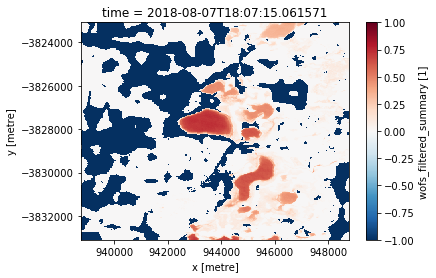

In [7]:
wofs_filtered_summary.wofs_filtered_summary.isel(time=0).plot()

## Plot the percentage of time that this area was wet

xarray dataset has no spatial data; defaulting to plotting without coordinates. This can often be resolved by adding `keep_attrs = True` during an aggregation step


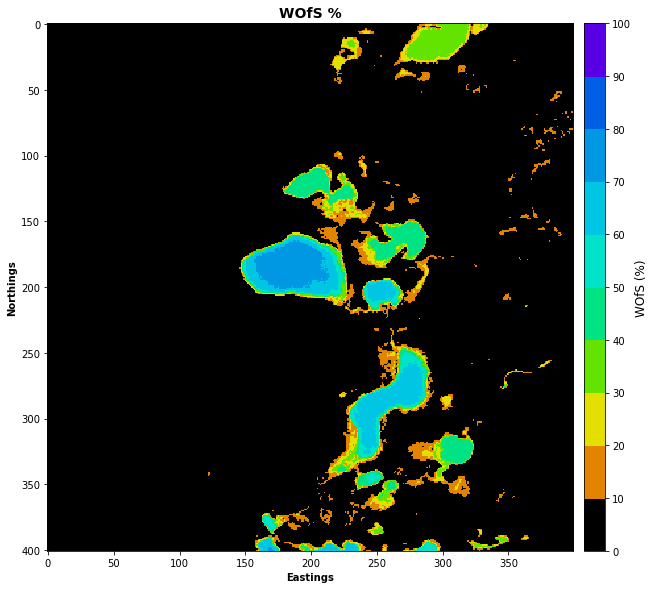

In [20]:
#this contains a sneaky workaround - currently plot_WOfS is expecting values from 0 to 100
DEAPlotting.plot_WOfS(wofs_filtered_summary.wofs_filtered_summary.isel(time=0)*100)
#ignore the error message about spatial data.. 
#save your image
plt.savefig(savefilepath+'WOfS_summary.png')

## WOfS feature layers (WOFLs) 

### load the wofs feature layers (wofls) 

In [9]:
#load wofs feature layers
#wofls = dc.load(product = 'wofs_albers', like=ls578_ds, fuse_func=wofs_fuser)
wofls = dc.load(product = 'wofs_albers',fuse_func=wofs_fuser, **query)

In [23]:
### take a look at your dataset

In [21]:
wofls

<xarray.Dataset>
Dimensions:  (time: 82, x: 400, y: 401)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-03T00:23:28 ... 2019-01-01T00:21:04
  * y        (y) float64 -3.823e+06 -3.823e+06 ... -3.833e+06 -3.833e+06
  * x        (x) float64 9.388e+05 9.388e+05 9.388e+05 ... 9.487e+05 9.488e+05
Data variables:
    water    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:3577

### Two ways of displaying what the values in the wofs data mean:
WOfS uses [bit flags](http://datacube-core.readthedocs.io/en/latest/dev/api/masking.html) to flag pixels as 'wet' or otherwise

In [10]:
masking.describe_variable_flags(wofls, with_pandas=True)

,bits,values,description
cloud,6,"{'0': False, '1': True}",Cloudy
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},Clear and dry
high_slope,4,"{'0': False, '1': True}",High slope
nodata,0,{'1': True},No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing over over/undersaturated
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",Terrain shadow or low solar angle
water_observed,7,"{'0': False, '1': True}",Classified as water by the decision tree
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


In [11]:
for key in wofls.water.flags_definition.keys():
    print('{}  {}'.format(key, wofls.water.flags_definition[key]))

dry  {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'0': True}, 'description': 'Clear and dry'}
sea  {'bits': 2, 'values': {'0': False, '1': True}, 'description': 'Sea'}
wet  {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'128': True}, 'description': 'Clear and Wet'}
cloud  {'bits': 6, 'values': {'0': False, '1': True}, 'description': 'Cloudy'}
nodata  {'bits': 0, 'values': {'1': True}, 'description': 'No data'}
high_slope  {'bits': 4, 'values': {'0': False, '1': True}, 'description': 'High slope'}
cloud_shadow  {'bits': 5, 'values': {'0': False, '1': True}, 'description': 'Cloud shadow'}
noncontiguous  {'bits': 1, 'values': {'0': False, '1': True}, 'description': 'At least one EO band is missing over over/undersaturated'}
water_observed  {'bits': 7, 'values': {'0': False, '1': True}, 'description': 'Classified as water by the decision tree'}
terrain_or_low_angle  {'bits': 3, 'values': {'0': False, '1': True}, 'description': 'Terrain shadow or low solar angle'}


### Here is what the WOFL mask looks like on one timestep:

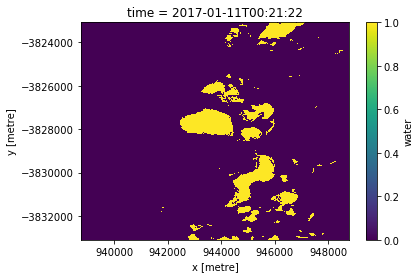

In [12]:
wetwofl = masking.make_mask(wofls, wet=True)
wetwofl.water.isel(time=1).plot()
#drywofl = masking.make_mask(wofls, dry=True)
#drywofl.water.isel(time=0).plot()

## Save WOfS Summary to NetCDF

In [16]:
try:
    DEADataHandling.write_your_netcdf(wofs_filtered_summary, 'WOfS_filtered', savefilepath+'wofs_filtered_summary'+'.nc', crs = wofs_filtered_summary.crs)
#complain if the file already exists but don't fail    
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
print('wrote to netCDF' )

wrote to netCDF


## Save WOfLs to GeoTIFF

In [24]:
ds = wofls
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    #drop the time dimension for only one timestep
    #write the dataset without the data percentage to file
    ds1 = ds.squeeze()
    #ds1 = ds1.drop('data_perc')
    write_geotiff(savefilepath+'WOfLs_'+'.tif', ds1)

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    #ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        try:
            write_geotiff(savefilepath+'WOfLs_'+str(timestep)+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

multiple timesteps
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to GeoTIFF
wrote to Geo

## References
1. GA, 2017. *Water Observations from Space 2.1.5 Product Description.* https://cmi.ga.gov.au/wo_25_2.1.5

2. Mueller, et al. 2015., *Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia*, Remote Sensing of Environment. https://doi.org/10.1016/j.rse.2015.11.003

GA, 2017. *Water Observations from Space Statistics 25m 2.1.5*, https://cmi.ga.gov.au/wo-stats_25_2.1.5


https://github.com/GeoscienceAustralia/wofs

GA, 2017. *Water Observations from Space Filtered Statistics 25m 2.1.5 Product Description*
https://data.dea.ga.gov.au/WOfS/filtered_summary/v2.1.0/Product%20Description.pdf